Use naive way to do the real data analysis

1. use cov
2. extract psd from 4 bands, and do regression

In [1]:
RUN_PYTHON_SCRIPT = False
#OUTLIER_IDXS = dict(AD=[], ctrl=[])
OUTLIER_IDXS = dict(AD=[49], ctrl=[14, 19, 30, 38])
SAVED_FOLDER = "real_data_nlinear_nostd"
DATA = ["AD88_matlab_1-45.pkl", "Ctrl92_matlab_1-45.pkl"]

['AD88_matlab_1-45.pkl', 'Ctrl92_matlab_1-45.pkl']

In [2]:
import sys
sys.path.append("../../mypkg")


In [3]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from numbers import Number
import itertools

from easydict import EasyDict as edict
from tqdm import trange, tqdm
from scipy.io import loadmat
from pprint import pprint
from IPython.display import display
from joblib import Parallel, delayed

In [4]:
# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

In [5]:
from constants import DATA_ROOT, RES_ROOT, FIG_ROOT, MIDRES_ROOT
from hdf_utils.data_gen import gen_simu_sinica_dataset
from hdf_utils.SIS import SIS_GLIM
from utils.matrix import col_vec_fn, col_vec2mat_fn, conju_grad, svd_inverse, cholesky_inv
from utils.functions import logit_fn
from utils.misc import save_pkl, load_pkl
from splines import obt_bsp_obasis_Rfn, obt_bsp_basis_Rfn_wrapper
from projection import euclidean_proj_l1ball
from optimization.opt import HDHTOpt
from hdf_utils.fns_sinica import  fourier_basis_fn

from joblib import Parallel, delayed

In [6]:
plt.style.use(FIG_ROOT/"base.mplstyle")

In [7]:
torch.set_default_tensor_type(torch.DoubleTensor)
def_dtype = torch.get_default_dtype()

torch.float64

# Load  data and prepare

In [8]:
data_root = DATA_ROOT/"AD_vs_Ctrl_PSD/";
AD_PSD = load_pkl(data_root/DATA[0]);
ctrl_PSD = load_pkl(data_root/DATA[1]);
df0= pd.read_csv(data_root/"AllDataBaselineOrdered_r_ncpt.csv");
df1= pd.read_csv(data_root/"AllDataBaselineOrdered_r_ncpt_more.csv");
df1 = df1.set_index("RID")
df0 = df0.set_index("RID");
df1 = df1.reindex(df0.index)
baseline = df1

baseline["Gender_binary"] = baseline["Gender"].apply(lambda x: 0 if x=="female" else 1);
baseline["Grp_binary"] = baseline["Grp"].apply(lambda x: 1 if x=="AD" else 0);

Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/real_data/../../mypkg/../data/AD_vs_Ctrl_PSD/AD88_matlab_1-45.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/real_data/../../mypkg/../data/AD_vs_Ctrl_PSD/Ctrl92_matlab_1-45.pkl


In [9]:
# The outlier idxs to rm
outlier_idxs = np.concatenate([OUTLIER_IDXS["AD"], len(AD_PSD.PSDs)+np.array(OUTLIER_IDXS["ctrl"])])
outlier_idxs = outlier_idxs.astype(int)

# make PSD in dB and std 
raw_X = np.concatenate([AD_PSD.PSDs, ctrl_PSD.PSDs]); #n x d x npts
X_dB = 10*np.log10(raw_X);
outlier_idxs2 = np.where(X_dB.mean(axis=(1, 2))<0)
#X = (X_dB - X_dB.mean(axis=-1, keepdims=1))/X_dB.std(axis=-1, keepdims=1);
X = X_dB

Y = np.array(baseline["MMSE"])[:X.shape[0]];
# if logi
Yb = np.array(baseline["Grp_binary"])[:X.shape[0]];

#sel_cov = ["Gender_binary", "MEG_Age"]
sel_cov = ["Gender_binary", "MEG_Age","Education"]
Z_raw = np.array(baseline[sel_cov])[:X.shape[0]];

grp_idxs = np.array(baseline["Grp"])[:X.shape[0]];

outlier_idxs = np.sort(np.union1d(outlier_idxs, outlier_idxs2))

# remove outliers
X = np.delete(X, outlier_idxs, axis=0)
Y = np.delete(Y, outlier_idxs, axis=0)
Yb = np.delete(Yb, outlier_idxs, axis=0)
Z_raw = np.delete(Z_raw, outlier_idxs, axis=0)
grp_idxs = np.delete(grp_idxs, outlier_idxs, axis=0)


#remove nan
keep_idx = ~np.bitwise_or(np.isnan(Y), np.isnan(Z_raw.sum(axis=1)));
X = X[keep_idx];
Y = Y[keep_idx]
Yb = Yb[keep_idx]
Z_raw = Z_raw[keep_idx]
grp_idxs = grp_idxs[keep_idx]

Z = np.concatenate([np.ones((Z_raw.shape[0], 1)), Z_raw], axis=1); # add intercept



freqs = AD_PSD.freqs.reshape(-1);
X = X[:, :, np.bitwise_and(freqs>=2, freqs<=35)]
freqs = freqs[np.bitwise_and(freqs>=2, freqs<=35)]

print(X.shape, Y.shape, Z.shape)

all_data = edict()
all_data.X = torch.tensor(X)
all_data.Y = torch.tensor(Y)
all_data.Z = torch.tensor(Z)


(143, 68, 74) (143,) (143, 4)


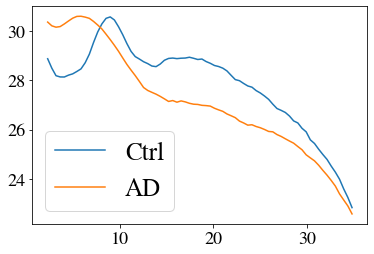

In [10]:
vec1 = all_data.X[grp_idxs=="AD"].mean(axis=(0, 1))
vec2 = all_data.X[grp_idxs=="Ctrl"].mean(axis=(0, 1))
plt.plot(freqs, vec2, label="Ctrl")
plt.plot(freqs, vec1, label="AD")
plt.legend()

In [11]:
# atlas
rois = np.loadtxt(DATA_ROOT/"dk68_utils/ROI_order_DK68.txt", dtype=str);

# Param and fns

## Params

In [12]:
save_dir = RES_ROOT/SAVED_FOLDER
if not save_dir.exists():
    save_dir.mkdir()

In [13]:
bands_cut = edict()
bands_cut.delta = [2, 4]
bands_cut.theta = [4, 8]
bands_cut.delta_theta = [2, 8]
bands_cut.alpha = [8, 12]
bands_cut.beta = [12, 35]
bands_cut.pts = [4, 8, 12, 35]

cut_pts = np.abs(freqs.reshape(-1, 1) - bands_cut.pts).argmin(axis=0)

kys = ["delta", "theta", "alpha", "beta", "all"]

['delta', 'theta', 'alpha', 'beta', 'all']

In [14]:
import matplotlib.patches as mpatches
from nilearn import plotting
import matplotlib as mpl
from utils.brain_plot import get_bg_data
def _brain_plot(vec, cmap="Reds", threshold=None):
    root = DATA_ROOT/"dk68_utils/"
    h = 0.43
    
    XYZsl = np.loadtxt(root/"MyBrainMesh_ICBM152_surf_sm20_XYZs_left.txt")
    facesl = np.loadtxt(root/"MyBrainMesh_ICBM152_surf_sm20_faces_left.txt").astype(np.int64)
    roi_tmpl = np.loadtxt(root/"brain_tmp_left_DK68.txt");
    bg_datal = get_bg_data(XYZsl, facesl)
    
    XYZsr = np.loadtxt(root/"MyBrainMesh_ICBM152_surf_sm20_XYZs_right.txt")
    facesr = np.loadtxt(root/"MyBrainMesh_ICBM152_surf_sm20_faces_right.txt").astype(np.int64)
    roi_tmpr = np.loadtxt(root/"brain_tmp_right_DK68.txt");
    bg_datar = get_bg_data(XYZsr, facesr)
    
    # map vec to the template
    vecl = roi_tmpl.copy()
    vecr = roi_tmpr.copy()
    for roi_ix in range(1, 35):
        vecl[roi_tmpl==roi_ix] = vec[roi_ix-1]
        vecr[roi_tmpr==roi_ix] = vec[roi_ix-1+34]
        
    vmin, vmax = np.min(vec), np.max(vec)
    #fig, axs = plt.subplots(2, 2, figsize=[10, 10], subplot_kw={'projection': '3d'})
    fig = plt.figure(figsize=(10, 10))
    # left, bottom, width, height
    # facecolor make the bg  transparent
    ax1 = fig.add_axes([0.1,  0.5, h,  h], projection='3d',  facecolor='none')
    ax2 = fig.add_axes([0.15, 0.1, h,  h], projection='3d',  facecolor='none') 
    ax3 = fig.add_axes([0.5,  0.5, h,  h], projection='3d',  facecolor='none')
    ax4 = fig.add_axes([0.47, 0.1, h,  h], projection='3d',  facecolor='none')  
    
    plotting.plot_surf_roi([XYZsl, facesl], vecl, hemi='left', view="lateral", axes=ax1, 
                           bg_on_data=True, darkness=1.5, bg_map=bg_datal, # TO get the depth of the brain plot
                           colorbar=False, cmap=cmap, threshold=threshold, 
                           figure=fig, vmin=vmin, vmax=vmax);
    plotting.plot_surf_roi([XYZsl, facesl], vecl, hemi='left', view="medial", axes=ax2, 
                           bg_on_data=True, darkness=1.5, bg_map=bg_datal,
                           colorbar=False, cmap=cmap, threshold=threshold, 
                           figure=fig, vmin=vmin, vmax=vmax);
    plotting.plot_surf_roi([XYZsr, facesr], vecr, hemi='right', view="lateral", axes=ax3, 
                           bg_on_data=True, darkness=1.5, bg_map=bg_datar,
                           colorbar=False, cmap=cmap, threshold=threshold, 
                           figure=fig, vmin=vmin, vmax=vmax);
    plotting.plot_surf_roi([XYZsr, facesr], vecr, hemi='right', view="medial", axes=ax4, 
                           bg_on_data=True, darkness=1.5, bg_map=bg_datar,
                           colorbar=False, cmap=cmap, threshold=threshold, 
                           figure=fig, vmin=vmin, vmax=vmax);
    
    fig.text(0.12, 0.30, 'Medial', ha='center', va='center')
    fig.text(0.12, 0.72, 'Lateral', ha='center', va='center')
    fig.text(0.30, 0.87, 'Left', ha='center', va='center')
    fig.text(0.72, 0.87, 'Right', ha='center', va='center')
    #plt.suptitle("-log pvalues", fontsize=30)
    
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  
    cbar_ax = fig.add_axes([.91, .3, .03, .4])
    fig.colorbar(sm, cax=cbar_ax)
    return fig

In [15]:
def _get_psd_X(X, kys):
    """From raw X to get the features with PSD
    """
    X_psd = []
    for ky in kys:
        if not ky.startswith("all"):
            cuts = bands_cut[ky]
            kpidxs = np.bitwise_and(freqs>=cuts[0], freqs <cuts[1])
            X_sub = np.mean(X[:, kpidxs], axis=-1)
        else:
            X_sub = X.mean(axis=-1)
        X_psd.append(X_sub)
        
    X_psd = np.array(X_psd).T
    return X_psd

def _prepare_data(all_data, roi_ix, kys, cen_Y=True, std_X=True):
    """Prepare data for linear reg with roi_ix 
    args:
        roi_ix: start from 0
    return:
        Ycen: Y is centered
        Zext_std:Z is stded and has intercept col
    """
    X = all_data.X[:, roi_ix].numpy()
    Y = all_data.Y.numpy()
    Z = all_data.Z.numpy()
    X_psd = _get_psd_X(X, kys=kys)
    Zext = np.concatenate([Z, X_psd], axis=1)
    
    # center Y and std Zest
    Ycen = Y 
    if cen_Y:
        Ycen = Y - Y.mean()
    Zext_std = Zext
    if std_X:
        Zext_std[:,2:] = (Zext[:, 2:] - Zext[:, 2:].mean(axis=0, keepdims=1))/Zext[:, 2:].std(axis=0, keepdims=1)
    Zext_std = pd.DataFrame(Zext_std, columns=["int", "gender", "age", "edu"]+kys)
        
    return Ycen, Zext_std

# Analysis

delta
26 l.rostralanteriorcingulate 2.9476286357583394e-05
theta
26 l.rostralanteriorcingulate 8.1356562272227e-05
alpha
3 l.cuneus 6.850877766127716e-05
49 r.middletemporal 0.00010084112007127536
beta
3 l.cuneus 2.465367565112265e-06
7 l.inferiorparietal 7.007720741334193e-05
27 l.rostralmiddlefrontal 5.9184974075669626e-05
31 l.supramarginal 5.552158548267919e-05
37 r.cuneus 7.46247094164144e-05
49 r.middletemporal 0.00016532413930212962


{'delta': [26],
 'theta': [26],
 'alpha': [3, 49],
 'beta': [3, 7, 27, 31, 37, 49]}

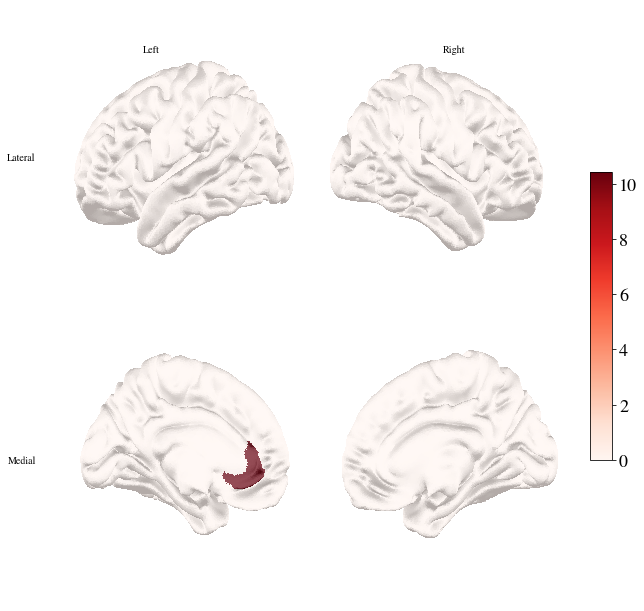

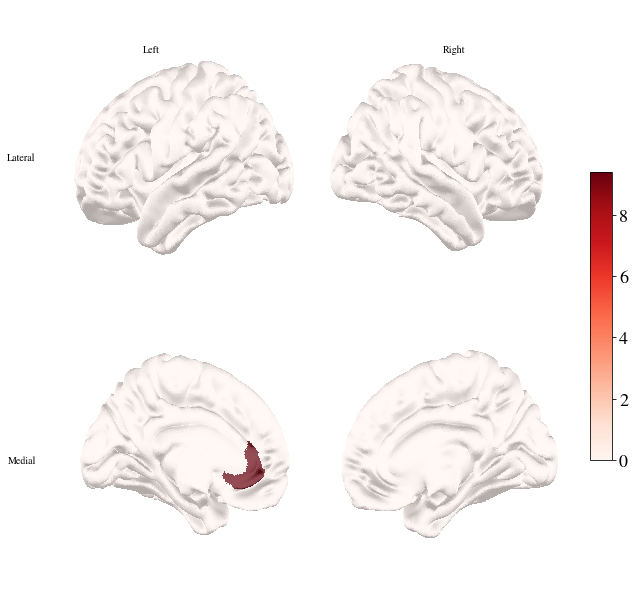

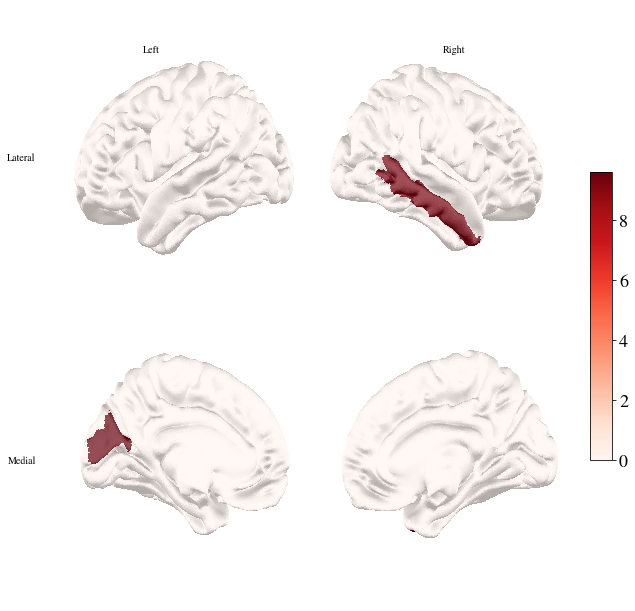

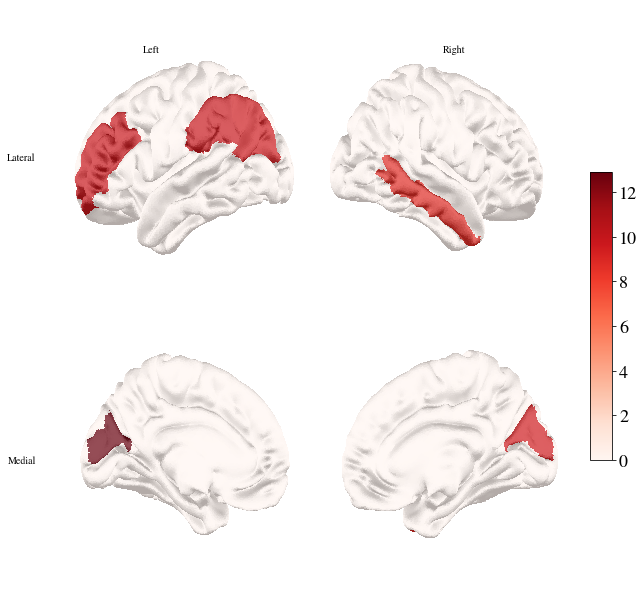

In [64]:
# get the sig roi in all four bands
import statsmodels.api as sm
cmap = "Reds"
#kys = ["delta_theta", "alpha", "beta"]
kys = ["delta", "theta", "alpha", "beta"]
cv = 0.05/68/4
all_rois = {}
for ky in kys:
    sig_rois = []
    print(ky)
    vec = []
    pvals = []
    for roi_ix in range(68):
        Y, X = _prepare_data(all_data, roi_ix=roi_ix, kys=[ky]);
        model0 = sm.OLS(Y, X).fit()
        pval = model0.pvalues[ky]
        pvals.append(pval)
        vec.append(-np.log(pval))
        if pval<cv:
            print(roi_ix, rois[roi_ix], pval)
            sig_rois.append(roi_ix)
    all_rois[ky] = sig_rois

    vec = np.array(vec)
    pvals = np.array(pvals)
    #vec = (vec-vec.min())/(vec.max()-vec.min())
    vec[pvals>=cv] = 0
    fig = _brain_plot(vec, cmap=cmap);
    plt.savefig(FIG_ROOT/f"{SAVED_FOLDER}_pval_brain_plot_naive{ky}.jpg")
    
all_rois

In [65]:
# logi on all sig roi and cov
# note that if a roi is sig in any of 1 band, 
# I only include info from the sig bands in that roi here
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score, roc_curve, f1_score
kys = ["delta", "theta", "alpha", "beta"]

Xs = []
for ky in kys:
    t_roi = all_rois[ky]
    for sig_roi in t_roi:
        psd = all_data.X[:, sig_roi].numpy()
        tpsd = _get_psd_X(psd, [ky])
        Xs.append(tpsd)

    
psd_Z = np.concatenate(Xs, axis=1);
#save_pkl(RES_ROOT/f"{SAVED_FOLDER}/info_from_sig_bands_naive.pkl", 
#         psd_Z, is_force=True)
bZ = np.concatenate([Z, psd_Z], axis=1);
bZ[:, 2:] = (bZ[:, 2:] - bZ[:, 2:].mean(axis=0))/bZ[:, 2:].std(axis=0);

clf = LogisticRegression(C=0.01, fit_intercept=False)
est_probs1 = cross_val_predict(clf, bZ, Yb, cv=10, method="predict_proba")[:, 1];
auc1 = roc_auc_score(Yb, est_probs1)

0.8762495001999201

In [66]:
# inference 
bZ1 = pd.DataFrame(bZ, columns=["int", "gender", "age", "edu"]+[f"feat.{i}" for i in range(1, 11)])
model0 = sm.OLS(Y, bZ1).fit()
model0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.552
Model:                            OLS   Adj. R-squared:                  0.507
Method:                 Least Squares   F-statistic:                     12.23
Date:                Fri, 26 Apr 2024   Prob (F-statistic):           5.28e-17
Time:                        15:21:39   Log-Likelihood:                -393.36
No. Observations:                 143   AIC:                             814.7
Df Residuals:                     129   BIC:                             856.2
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
int            0.1939      0.424      0.458      0.648      -0.644       1.032
gender        -0.5233      0.705     -0.742      0.460      -1.919       0.872
age            0.7121      0.367      1.942      0.054      -0.013       1.438
edu            0.6843      0.351      1.951      0.053      -0.010       1.378
feat.1        -0.9830      0.647     -1.519      0.131      -2.263       0.297
feat.2        -1.3475      0.667     -2.019      0.046      -2.668      -0.027
feat.3        -1.1649      0.894     -1.303      0.195      -2.934       0.604
feat.4        -0.0922      0.959     -0.096      0.924      -1.989       1.804
feat.5         2.4686      0.898      2.748      0.007       0.691       4.246
feat.6         0.0504      0.479      0.105      0.916      -0.896       0.997
feat.7         1.1507      0.384      2.995      0.003       0.391       1.911
feat.8         0.8181      0.470      1.740      0.084      -0.112       1.748
feat.9         0.0351      0.540      0.065      0.948      -1.033       1.103
feat.10        1.2221      0.906      1.349      0.180      -0.571       3.015
==============================================================================
Omnibus:                       14.965   Durbin-Watson:                   1.644
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               19.197
Skew:                          -0.627   Prob(JB):                     6.78e-05
Kurtosis:                       4.284   Cond. No.                         8.68
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

all
3 l.cuneus 0.00010450943033310505
27 l.rostralmiddlefrontal 0.0005950019446000499


{'all': [3, 27]}

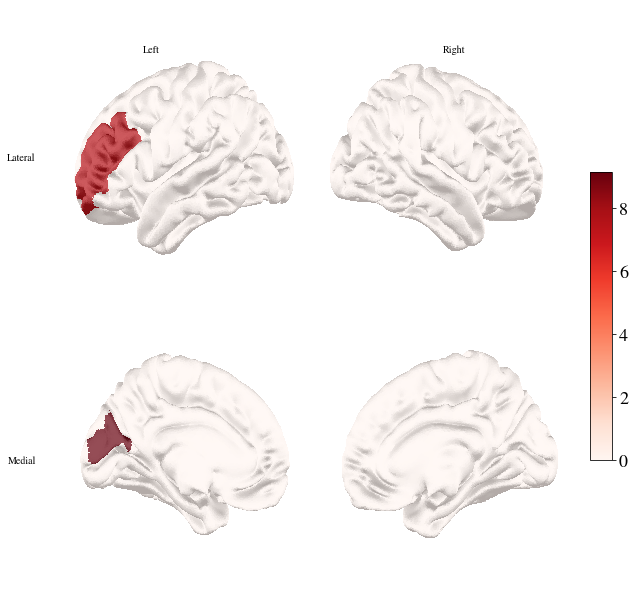

In [68]:
# get the sig roi not distinguish band
import statsmodels.api as sm
kys = ["all"]
all_rois0 = {}
for ky in kys:
    sig_rois = []
    print(ky)
    vec = []
    pvals = []
    for roi_ix in range(68):
        Y, X = _prepare_data(all_data, roi_ix=roi_ix, kys=[ky]);
        model0 = sm.OLS(Y, X).fit()
        pval = model0.pvalues[ky]
        pvals.append(pval)
        vec.append(-np.log(pval))
        if pval<0.05/68:
            print(roi_ix, rois[roi_ix], pval)
            sig_rois.append(roi_ix)
        
    vec = np.array(vec)
    pvals = np.array(pvals)
    #vec = (vec-vec.min())/(vec.max()-vec.min())
    vec[pvals>=0.05/68] = 0
    fig = _brain_plot(vec, cmap=cmap);
    plt.savefig(FIG_ROOT/f"{SAVED_FOLDER}_pval_brain_plot_naive{ky}.jpg")
    
    all_rois0[ky] = sig_rois

all_rois0

In [63]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score, roc_curve, f1_score
kys = ["all"]

Xs = []
for ky in kys:
    t_roi = all_rois0[ky]
    for sig_roi in t_roi:
        psd = all_data.X[:, sig_roi].numpy()
        tpsd = _get_psd_X(psd, [ky])
        Xs.append(tpsd)

    
psd_Z = np.concatenate(Xs, axis=1);
save_pkl(RES_ROOT/f"{SAVED_FOLDER}/info_from_sig_all_naive.pkl", 
         psd_Z, is_force=True)
bZ = np.concatenate([Z, psd_Z], axis=1);
bZ[:, 2:] = (bZ[:, 2:] - bZ[:, 2:].mean(axis=0))/bZ[:, 2:].std(axis=0);

clf = LogisticRegression(C=0.01, fit_intercept=False)
est_probs1 = cross_val_predict(clf, bZ, Yb, cv=10, method="predict_proba")[:, 1];
auc1 = roc_auc_score(Yb, est_probs1)

Save to /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/real_data/../../mypkg/../results/real_data_nlinear_nostd/info_from_sig_all_naive.pkl


0.7622950819672131